# Rotton Tomatoes Movie Review Sentiment Analysis
### How useful is TF-IDF weighing in sentiment analysis?

This kernel works with data from the Movie Review Sentiment Analysis Competition on Kaggle.com. More info can be found at https://nlp.stanford.edu/sentiment/.

In the report created by the Stanford research group, each sentence is seperated into it's component pieces and given a positive/negative scoring. This is summed up as a word tree to give each sentence an overall sentiment.
<img src="Capture.png">
*Image taken from nlp.stanford.edu*

The objective of this kernel is to explore using tf-idf weighting factors to assist traditional classifier models. Then we will compare these models to simple 'bag of words' text analysis options. Is TF-IDF underutilized in sentiment analysis?

## Step 1: Reading SA data

In [2]:
import csv
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.model_selection import train_test_split   
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

C:\Users\78598\anaconda4\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
train = pd.read_csv('../data/train.tsv', sep='\t')
test = pd.read_csv('../data/test.tsv',  sep='\t')
sampleSub = pd.read_csv('../data/sampleSubmission.csv')

## Step 2: Analysing data

### Dataframe analysis

In [6]:
print(train.shape, "\n", 
      test.shape
     )

(156060, 4) 
 (66292, 3)


In [7]:
print (train.isnull().values.any(), "\n",
      test.isnull().values.any()
      )

False 
 False


In [8]:
train.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [6]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Number of unique sentences in the training / testing dataset

In [7]:
len(train.groupby('SentenceId').nunique())

8529

In [8]:
len(test.groupby('SentenceId').nunique())

3310

Let's create a dataset with only full sentences. Exploring data this way will gives us cleaner graphs that aren't biased toward longer sentences. We can also add a label for the sentiment value to increased readability.

In [25]:
#Create df of full sentences创建完整句子
fullSent = train.loc[train.groupby('SentenceId')['PhraseId'].idxmin()]#能够获得到最小值的索引位置

#Change sentiment to increase readability改变情绪增加可读性
fullSent['sentiment_label'] = ''
Sentiment_Label = ['Negative', 'Somewhat Negative', 
                  'Neutral', 'Somewhat Positive', 'Positive']
for sent, label in enumerate(Sentiment_Label):#遍历
    fullSent.loc[train.Sentiment == sent, 'sentiment_label'] = label
    
fullSent.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
63,64,2,"This quiet , introspective and entertaining in...",4,Positive
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,Somewhat Negative
116,117,4,A positively thrilling combination of ethnogra...,3,Somewhat Positive
156,157,5,Aggressive self-glorification and a manipulati...,1,Somewhat Negative


## NLP Analysis

In natural language processing, the gold standard of text analysis is TF-IDF analysis. TF-IDF is short for "term frequency–inverse document frequency", and it focus on finding the 'valuable' classification words for each document. Term frequency of a word in a document increases it's score, and document frequency (the number of documents where the word shows up) decreases the score.

Scikit-learn provides a TfidfVectorizer class, which has the ability to remove common stop words (like a, the, and, or). I also created a CountVectorizer class object for comparison in the evaluation section below. Below we'll try to find the most 'valuable words' for each sentiment group. 

In [10]:
#Add non-helpful stopwords to stopword list将无用的stopwords添加到stopword列表中
Stopwords = list(ENGLISH_STOP_WORDS)
Stopwords.extend(['movie','movies','film','nt','rrb','lrb',
                      'make','work','like','story','time','little'])#在列表末尾一次性追加另一个列中的多个值

#Create tfidf vectorizer object & fit to full sentence training data创建tfidf矢量器
tfidf_vectorizor = TfidfVectorizer(min_df=5, #忽略低于在给出值文档频率的词条
                             max_df=0.5,#忽略高于给出值文档频率的文档词条
                             analyzer='word',#定义特征词
                             strip_accents='unicode',#预处理中去除编码规则
                             ngram_range=(1, 3),#要提取的ngram上下限范围
                             sublinear_tf=True, #使用1+log(tf)覆盖tf
                             smooth_idf=True,#通过加1到文档频率 防止除零 加一额外文档
                             use_idf=True,#重新计算权重
                             stop_words=Stopwords)

tfidf_vectorizor.fit(list(fullSent['Phrase']))


#Create bag of word vectorizer for comparison in evaluation section创建单词向量包 只考虑每个文本在训练文本中出现的频率
BoW_vectorizer = CountVectorizer(strip_accents='unicode',#在预处理中去除重音符号
                                 stop_words=Stopwords,#设置停用词
                                 ngram_range=(1,3),#词组切分长度
                                 analyzer='word',#word型
                                 min_df=5,#作阈值 文档频率小于它不会作关键字
                                 max_df=0.5)#作阈值 文档频率大于它不会作关键词

BoW_vectorizer.fit(list(fullSent['Phrase']))

CountVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 3),
                stop_words=['between', 'together', 'top', 'else', 'both', 'for',
                            'however', 'and', 'not', 'our', 'part', 'hereupon',
                            'we', 'whence', 'formerly', 'etc', 'hasnt', 'very',
                            'him', 'though', 'ourselves', 'to', 'same', 'again',
                            'few', 'us', 'its', 'can', 'ten', 'thereafter', ...],
                strip_accents='unicode')

In [11]:
#functions to create graphics below from tf-idf matrices创建下面tf-idf矩阵的图形
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=20):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=16):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs, num_class=9):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(num_class, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Word", labelpad=16, fontsize=16)
        ax.set_title(str(df.label) + ' Sentiment Class', fontsize=25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


The graphs below shows the words with the highest tf-idf score in each class. The matplotlib code is adapted from https://buhrmann.github.io/tfidf-analysis.html, a great analysis of what tf-idf scores can show you about a set of documents in a corpus. Note we use the full sentence dataset created above.

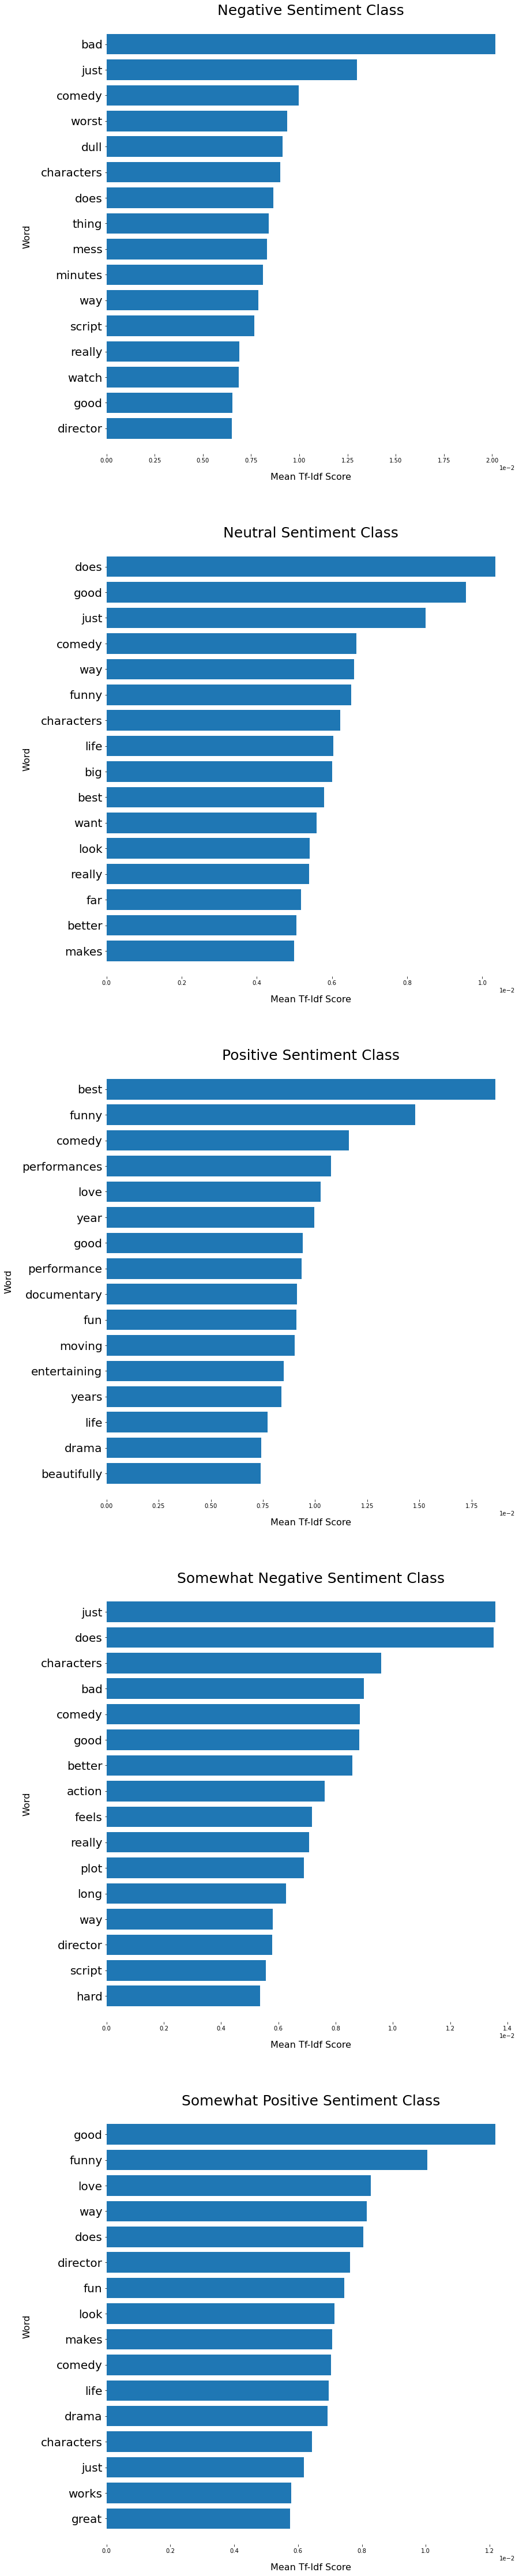

In [12]:
class_Xtr = tfidf_vectorizor.transform(fullSent['Phrase'])
class_y = fullSent['sentiment_label']
class_features = tfidf_vectorizor.get_feature_names()
class_top_dfs = top_feats_by_class(class_Xtr, class_y, class_features)
plot_tfidf_classfeats_h(class_top_dfs, 7)

## Part 3: Sentiment Analysis using Machine Learning Models

### Train/Test Splitting

In [13]:
phrase = np.array(train['Phrase'])
sentiment = np.array(train['Sentiment'])
# build train and test datasets
phrase_train, phrase_test, sentiment_train, sentiment_test = train_test_split(phrase, 
                                                                              sentiment, 
                                                                              test_size=0.2, 
                                                                              random_state=4)

#TF-IDF
train_tfidfmatrix = tfidf_vectorizor.fit_transform(phrase_train)
test_tfidfmatrix = tfidf_vectorizor.transform(phrase_test)

#Vectorizer (Bag of Words Model)
train_simplevector = BoW_vectorizer.transform(phrase_train)
test_simplevector = BoW_vectorizer.transform(phrase_test)

In [14]:
def train_model_predict (classifier, train_features, train_labels,
                      test_features):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    return predictions

### Naive Bayes Model

#### TF-IDF vectorization

In [15]:
model1 = MultinomialNB() 
NBPredictions = train_model_predict(model1, train_tfidfmatrix, sentiment_train,
                             test_tfidfmatrix)

#### 'Bag of Words' vectorization

In [16]:
NBPredictions2 = train_model_predict(model1, train_simplevector, sentiment_train,
                             test_simplevector)

### Logistic Regression Model

#### TF-IDF vectorization

In [17]:
model2 = LogisticRegression(solver = 'liblinear', multi_class = 'ovr')
LogisticRegressionPredictions = train_model_predict(model2, train_tfidfmatrix, sentiment_train,
                             test_tfidfmatrix)

#### 'Bag of Words' vectorization

In [18]:
LogisticRegressionPredictions2 = train_model_predict(model2, train_simplevector, sentiment_train,
                             test_simplevector)

## Part 4 : Evaluation

Since we don't care about certain types of scoring over others (ie weighing mislabeling more than correctly labeling), we'll use F1 scores as shorthand for how good the model is.

In [19]:
def get_metrics(true_labels, predicted_labels, feature):  
    print(feature)
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, 
                                               predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'), 4))
    print('Recall:', np.round(metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'), 4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'), 4))
    print('\n')
    

In [20]:
get_metrics(NBPredictions, sentiment_test, 'Naive Bayes & TF-IDF Scores: ')
get_metrics(NBPredictions2, sentiment_test, 'Naive Bayes & Bag of Words Scores: ')

Naive Bayes & TF-IDF Scores: 
Accuracy: 0.6122
Precision: 0.7546
Recall: 0.6122
F1 Score: 0.6577


Naive Bayes & Bag of Words Scores: 
Accuracy: 0.599
Precision: 0.7258
Recall: 0.599
F1 Score: 0.6386




In [21]:
get_metrics(LogisticRegressionPredictions, sentiment_test, 'Logistic Regression & TF-IDF Scores: ')
get_metrics(LogisticRegressionPredictions2, sentiment_test, 'Logistic Regression & Bag of Words Scores: ')

Logistic Regression & TF-IDF Scores: 
Accuracy: 0.6243
Precision: 0.7451
Recall: 0.6243
F1 Score: 0.6615


Logistic Regression & Bag of Words Scores: 
Accuracy: 0.6069
Precision: 0.7419
Recall: 0.6069
F1 Score: 0.6485




### Table of F1 scores of different modelling methods

|            |NaiveBayes|LogReg|
|------------|----------|------|
|   TF-IDF   | 0.6577   |0.6615|
|Bag of Words| 0.6386   |0.6485|

## Part 5: Conclusion

TF-IDF weighing does have a positive effect on the correctness of the model. The difference between a bag-of-words weighing schema and TF-IDF schema is slight but consistent between both classifiers.

We could also run a GridSearch to find the most correct parameters for each model, though we run the risk of overfitting for the Kaggle test data. Future testing can be done on different models and more or less optimizeed ones - including nerual networks.

References and sources used:

https://buhrmann.github.io/tfidf-analysis.html
http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
https://www.dataquest.io/blog/naive-bayes-tutorial/

#### Application to competition test set

In [22]:
train_tfidf = tfidf_vectorizor.fit_transform(train['Phrase'])
model2.fit(train_tfidf, train['Sentiment'])
test_tfidf = tfidf_vectorizor.transform(test['Phrase'])
predictions = model2.predict(test_tfidf)

test['Sentiment'] = predictions
submission = test[['PhraseId','Sentiment']]
submission.to_csv('submission.csv',index=False)